In [111]:
import matplotlib.pyplot as plt

In [112]:
station_name = "Soltau"
test_year = 2014
at_iterations = "final"

In [113]:
from climatereconstructionai import evaluate
import os
import regex as re

def evaluate_wrapper(use_time_context = True, iter = "final", station = station_name):

    snapshot_folder_name = f"snapshots_{station.lower()}"
    if not use_time_context:
        snapshot_folder_name += "_backup"

    # copy "test_args_template.txt" to "test_args_temp.txt"
    # while replacing:

    replace_dir = {
        "STATIONNAME" : station.lower(),
        "ITERATION" : str(iter),
        "SNAPSHOTDIR" : snapshot_folder_name,
    }

    template_file = "test_args_template.txt" if use_time_context else "test_args_template_no-time.txt"
    temp_file = "test_args_temp.txt"


    with open(template_file, "r") as f:
        lines = f.readlines()
        with open(temp_file, "w") as f2:
            for line in lines:
                for key in replace_dir:
                    line = re.sub(key, replace_dir[key], line)
                f2.write(line)
                
            # save and close
            f2.close()

    evaluate(temp_file)

    os.remove(temp_file)

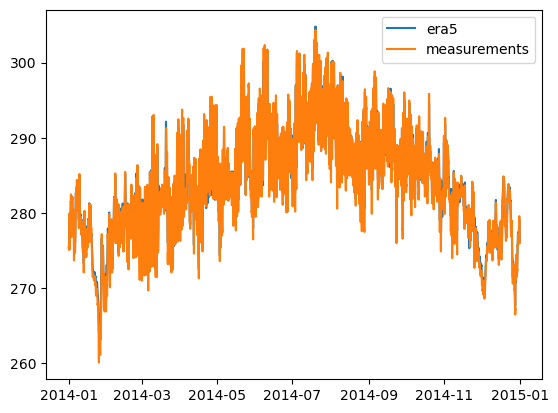

In [114]:
import xarray as xr
from utils import DataSet, DatasetPlotter
import numpy as np
import os

test_folder_path = "/work/bm1159/XCES/xces-work/k203179/data/test"
output_file_path = "outputs/output_output.nc"
era5_file = f"{test_folder_path}/era5_for_{station_name.lower()}.nc"

# get measurements values

measurements_data = xr.open_dataset(test_folder_path + f"/reality_{station_name.lower()}.nc")

# plot era5 and output at timesteps [x, ...]

era5_ds = DataSet(era5_file)
era5_data = xr.open_dataset(era5_file)

plt.plot(era5_data["time"], era5_data["tas"].mean(axis=(1,2)), label = "era5")
plt.plot(measurements_data["time"], measurements_data["tas"].mean(axis=(1,2)), label = "measurements")
plt.legend()
plt.show()


## Evaluate with no timecontext

In [115]:
evaluate_wrapper(use_time_context = False, iter = at_iterations, station = station_name)
output_no_time_ds = DataSet(output_file_path, name = "Reconstructed without time context")
output_no_time_data = xr.open_dataset(output_file_path)

/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/climatereconstructionai/utils/normalizer.py:10: RuntimeWarning: Mean of empty slice
  img_mean.append(np.nanmean(np.array(img_data[i])))
/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


## Evaluate with timecontex

In [116]:
evaluate_wrapper(use_time_context = True, iter = at_iterations, station = station_name)
output_with_time_ds = DataSet(output_file_path, name="Reconstructed with time context")
output_with_time_data = xr.open_dataset(output_file_path)

/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/climatereconstructionai/utils/normalizer.py:10: RuntimeWarning: Mean of empty slice
  img_mean.append(np.nanmean(np.array(img_data[i])))
/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|██████████| 1/1 [00:07<00:00,  7.79s/it]


In [117]:
print("Dimensions:", era5_ds.time[-1], output_no_time_ds.time[-1])

plot_timestep = len(era5_ds.time) - 1

vmin = min(
    np.min(era5_ds.dataset.variables['tas'][plot_timestep, :, :]),
    np.min(output_no_time_ds.dataset.variables['tas'][plot_timestep, :, :])
)

vmax = max(
    np.max(era5_ds.dataset.variables['tas'][plot_timestep, :, :]),
    np.max(output_no_time_ds.dataset.variables['tas'][plot_timestep, :, :])
)

Dimensions: 8760.0 8760.0


## Last Output point in time-context-output is far off:

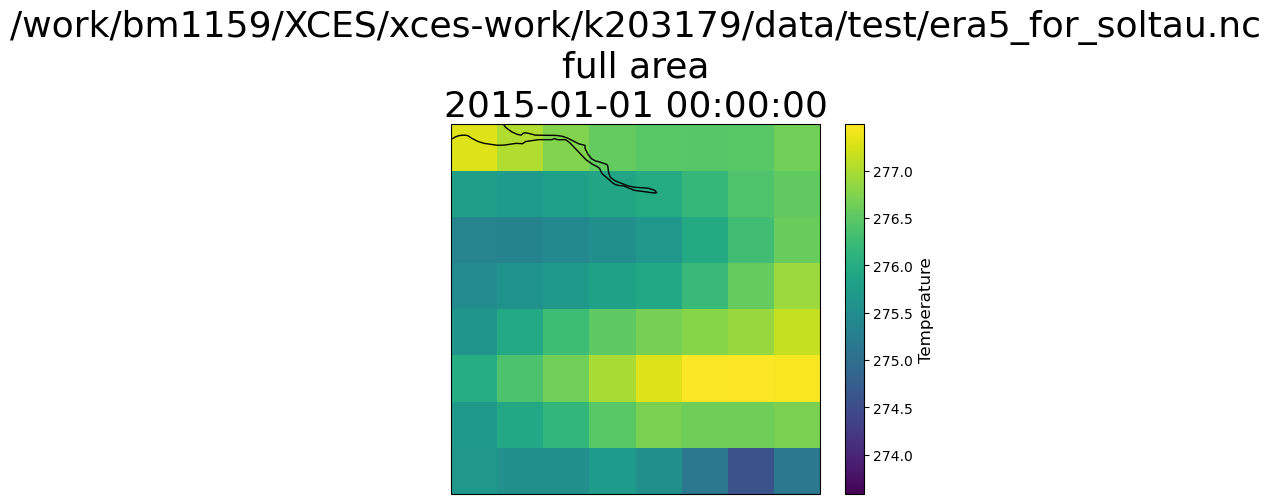

In [118]:

plotter = DatasetPlotter(era5_ds)
plotter.time_index_list = [plot_timestep]
plotter.vmin = vmin
plotter.vmax = vmax
plotter.plot()

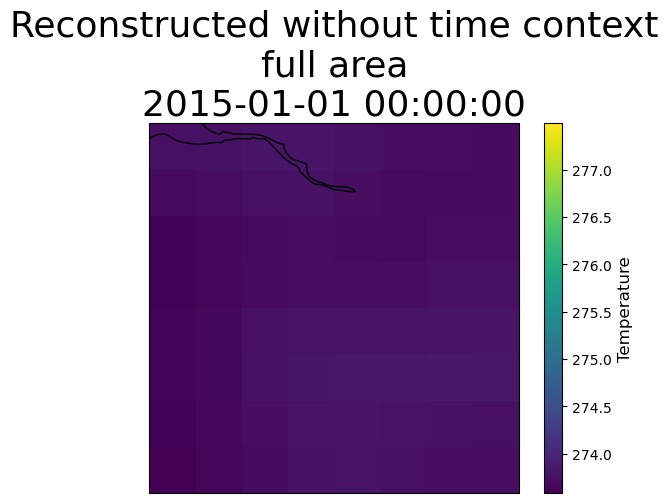

In [119]:
plotter = DatasetPlotter(output_no_time_ds)
plotter.time_index_list = [plot_timestep]
plotter.vmin = vmin
plotter.vmax = vmax
plotter.plot()

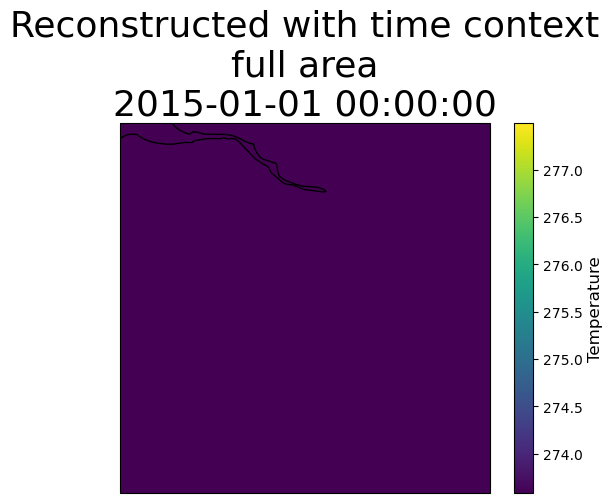

In [120]:
plotter = DatasetPlotter(output_with_time_ds)
plotter.time_index_list = [plot_timestep]
plotter.vmin = vmin
plotter.vmax = vmax
plotter.plot()

In [121]:
# get coordinates from measurements nc file
import numpy as np

station_lon, station_lat = measurements_data.lon.values[0], measurements_data.lat.values[0]
print(f"station is at {station_lon}, {station_lat}")

# get nearest coordinates in era5
def get_left_right_nearest_elem_in_sorted_array(array, value):
    length = len(array)
    left = len(list(filter(lambda x: x <= value, array))) - 1
    right = length - len(list(filter(lambda x: x >= value, array)))
    nearest = min(left, right, key=lambda x: abs(array[x] - value))
    return left, right, nearest

test_array = [1, 2, 3, 4, 5, 6, 7, 8]
test_search = 5.51

print(f"searching for {test_search} in {test_array}")
left_idx, right_idx, nearest_idx =  get_left_right_nearest_elem_in_sorted_array(test_array, test_search)
print(f"idx left to {test_search} is {left_idx}, idx right to {test_search} is {right_idx}, nearest idx is {nearest_idx}")
print(f"mid crop: {test_array[left_idx:right_idx+1]}")


station is at 9.793, 52.96
searching for 5.51 in [1, 2, 3, 4, 5, 6, 7, 8]
idx left to 5.51 is 4, idx right to 5.51 is 5, nearest idx is 5
mid crop: [5, 6]


In [122]:
def era_vs_reconstructed_comparision_to_df(era5_data, reconstructed_with_time_data, reconstructed_no_time_data):

    lon_left_idx, lon_right_idx, lon_nearest_idx = get_left_right_nearest_elem_in_sorted_array(era5_data.lon.values, station_lon % 360)
    lat_left_idx, lat_right_idx, lat_nearest_idx = get_left_right_nearest_elem_in_sorted_array(era5_data.lat.values, station_lat)

    era5_nearest_values = era5_data.variables["tas"][:, lon_nearest_idx, lat_nearest_idx]
    
    reconstructed_with_time_data_values = reconstructed_with_time_data.variables["tas"].stack(grid=['lat', 'lon']).values
    reconstructed_no_time_data_values = reconstructed_no_time_data.variables["tas"].stack(grid=['lat', 'lon']).values
    measurements_data_values = measurements_data.variables["tas"][...].mean(axis=(1,2))


    # timeaxis 
    time = measurements_data.variables["time"][:]
    
    import pandas as pd

    # create dataframe with all values
    df = pd.DataFrame()

    df["time"] = time

    # index should be time
    df.set_index("time", inplace=True)

    df["era5_nearest"] = era5_nearest_values
    df["reconstructed_median"] = [np.median(x) for x in reconstructed_no_time_data_values]
    df["reconstructed_with_time_context_median"] = [np.median(x) for x in reconstructed_with_time_data_values]
    
    df["measurements"] = measurements_data_values

    return df


# Generate Dataframe
- makes resampling easier

In [123]:
hourly_df = era_vs_reconstructed_comparision_to_df(era5_data, output_with_time_data, output_no_time_data)

# drop last 1 hour
hourly_df = hourly_df[:-1]

# print a section of the df

start_print_date = "2021-12-31"
end_print_date = "2022-12-31"

hourly_df[start_print_date:end_print_date]

,era5_nearest,reconstructed_median,reconstructed_with_time_context_median,measurements
time,,,,


# Implement plotting method of dataframe

In [124]:
def plot_n_steps_of_df(df, as_delta, n=None, title=None):

    time = df.index.values
    if n is None:
        n = len(df)
    
    # random slice of n consecutive datapoints
    import random
    slice_start = random.randint(0, len(time) - n)
    time_slice = slice(slice_start, slice_start + n)

    time = time[time_slice]

   # era5_mid_values = df["era5_mid"].values -273.15
    era5_nearest_values = df["era5_nearest"].values - 273.15
    reconstructed_median_values = df["reconstructed_median"].values - 273.15
    reconstructed_median_with_time_context_values = df["reconstructed_with_time_context_median"].values - 273.15
    
    measurements_values = df["measurements"].values - 273.15
    
    rmse_reconstructed = np.sqrt(np.sum((reconstructed_median_values[time_slice] - measurements_values[time_slice])**2) / len(time))
    rmse_reconstructed_with_time_context = np.sqrt(np.sum((reconstructed_median_with_time_context_values[time_slice] - measurements_values[time_slice])**2) / len(time)) 
    rmse_era5_nearest = np.sqrt(np.sum((era5_nearest_values[time_slice] - measurements_values[time_slice])**2) / len(time))
    
    correlation_reconstructed = np.corrcoef(reconstructed_median_values[time_slice], measurements_values[time_slice])[0,1]
    correlation_reconstructed_with_time_context = np.corrcoef(reconstructed_median_with_time_context_values[time_slice], measurements_values[time_slice])[0,1]
    correlation_era5_nearest = np.corrcoef(era5_nearest_values[time_slice], measurements_values[time_slice])[0,1]
    
    if as_delta:
     #   era5_mid_values = era5_mid_values - measurements_values
        era5_nearest_values = era5_nearest_values - measurements_values
        reconstructed_median_values = reconstructed_median_values - measurements_values
        reconstructed_median_with_time_context_values = reconstructed_median_with_time_context_values - measurements_values
        measurements_values = measurements_values - measurements_values  
        
        # y-axis title, temperature difference  
        plt.ylabel("Delta calculated by subtracting measurement data [C°]")

    else:
        plt.ylabel("Temperature at surface [C°]")
    

    plt.plot(time, era5_nearest_values[time_slice], label="ERA5 nearest point", color="red")
    # plt.plot(time, era5_mid_values[time_slice], label="ERA5 nearest 4 points")
    
   
    plt.plot(time, reconstructed_median_values[time_slice], label="Reconstructed", color="blue")
    plt.plot(time, reconstructed_median_with_time_context_values[time_slice], label="Reconstructed with time context", color="green") 
    plt.plot(time, measurements_values[time_slice], label="Measurements", color="black")

    # x-axis labels 90 degrees
    plt.xticks(rotation=45)
    
    # title
    if title is not None:
        plt.title(title)
    
    
    # font size of legend
    plt.rcParams.update({'font.size': 10})
    
    # font size of axis labels
    plt.rcParams.update({'axes.labelsize': 12})
    
    # font size of title
    plt.rcParams.update({'axes.titlesize': 26})

    plt.legend()
    # position legend below chart to the right
    plt.legend(bbox_to_anchor=(1, 1.15), loc='upper right', borderaxespad=0.)
    
        
    # text below diagram with RMSE and Correlation in fontsize 10
    plt.text(0.1,0.95, f"RMSE reconstructed: {rmse_reconstructed:.2f} C°\n" +
             f"RMSE reconstr. (time context): {rmse_reconstructed_with_time_context:.2f} C°\n" + 
             f"RMSE ERA5 nearest point: {rmse_era5_nearest:.2f} C°",
            
             fontsize=10, transform=plt.gcf().transFigure)
    
    plt.text(0.3, 0.95, f"Correlation reconstructed: {correlation_reconstructed:.3f}\n" + 
             f"Correlation reconstr. (time context): {correlation_reconstructed_with_time_context:.3f}\n" +
             f"Correlation ERA5 nearest point: {correlation_era5_nearest:.3f}",
             
             fontsize = 10, transform=plt.gcf().transFigure)
    
    # figure size A4 landscape
    plt.gcf().set_size_inches(16, 8)
    
    plt.show()

# Hourly Analysis

## ...over the full year

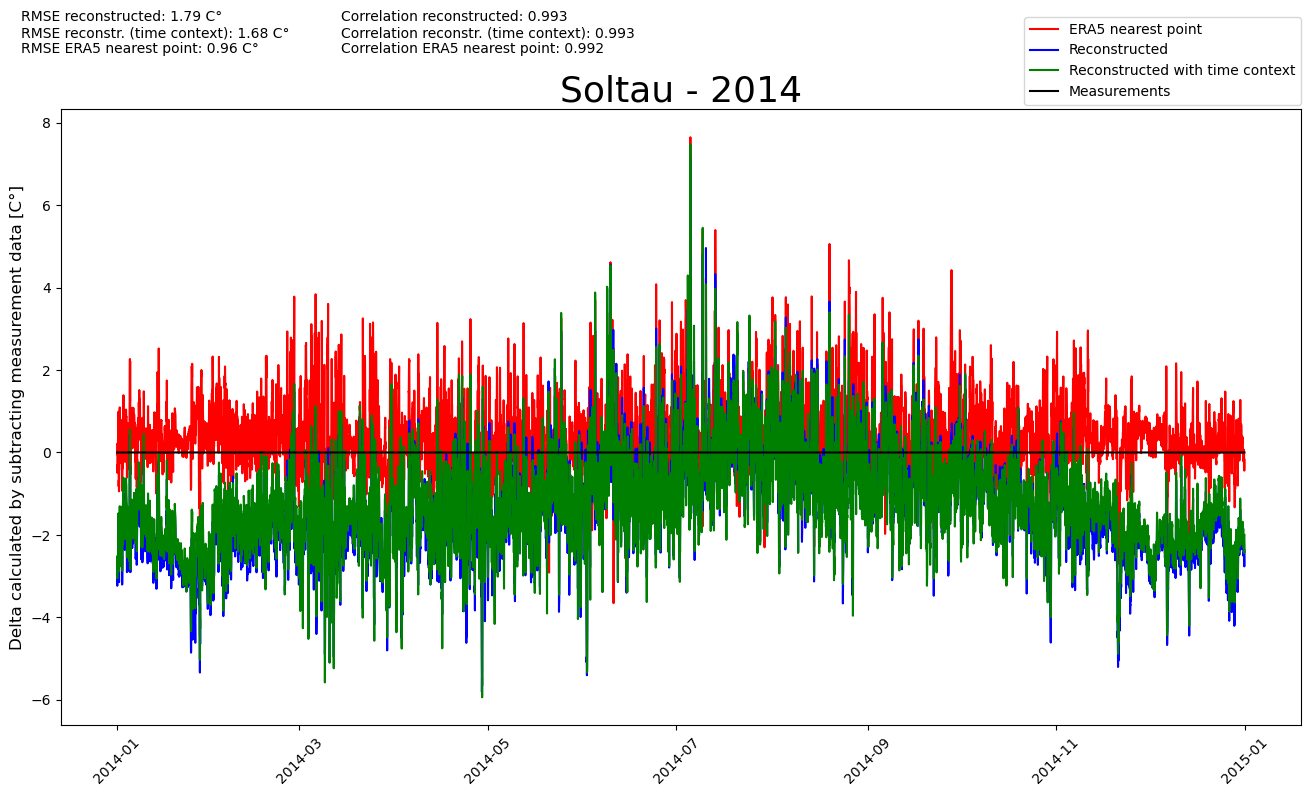

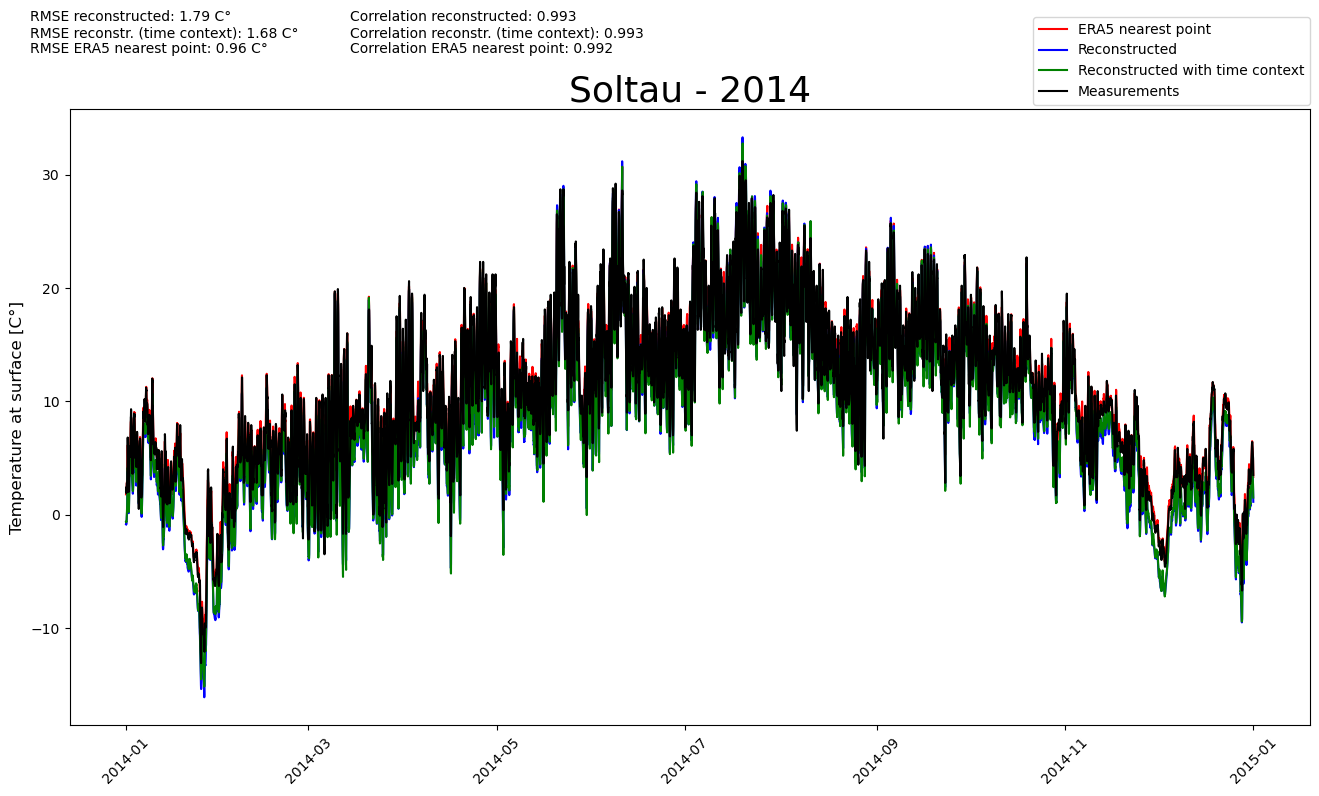

In [125]:
title = f"{'Denver' if station_name == 'Marshall' else station_name} - {test_year}"
plot_n_steps_of_df(hourly_df, as_delta=True, title=title)
plot_n_steps_of_df(hourly_df, as_delta=False, title=title)

## ...over random weeks

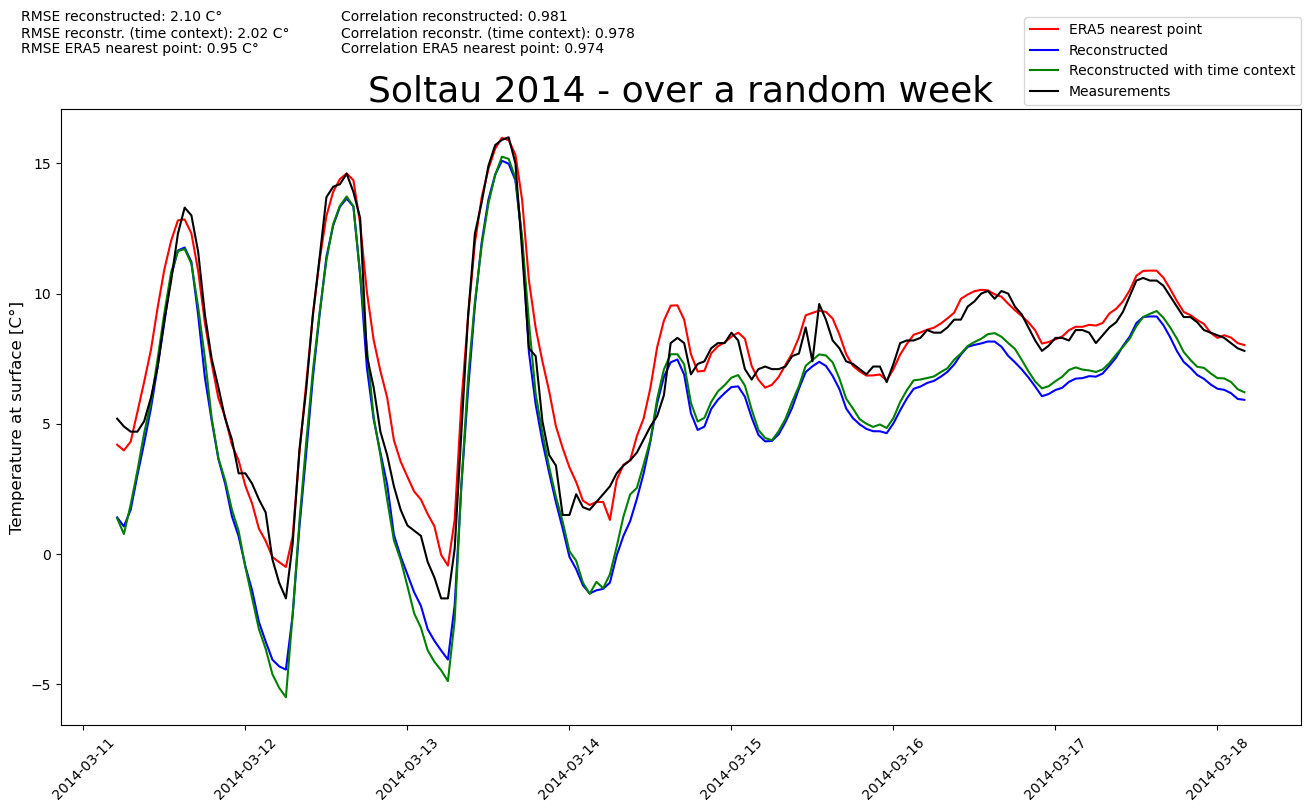

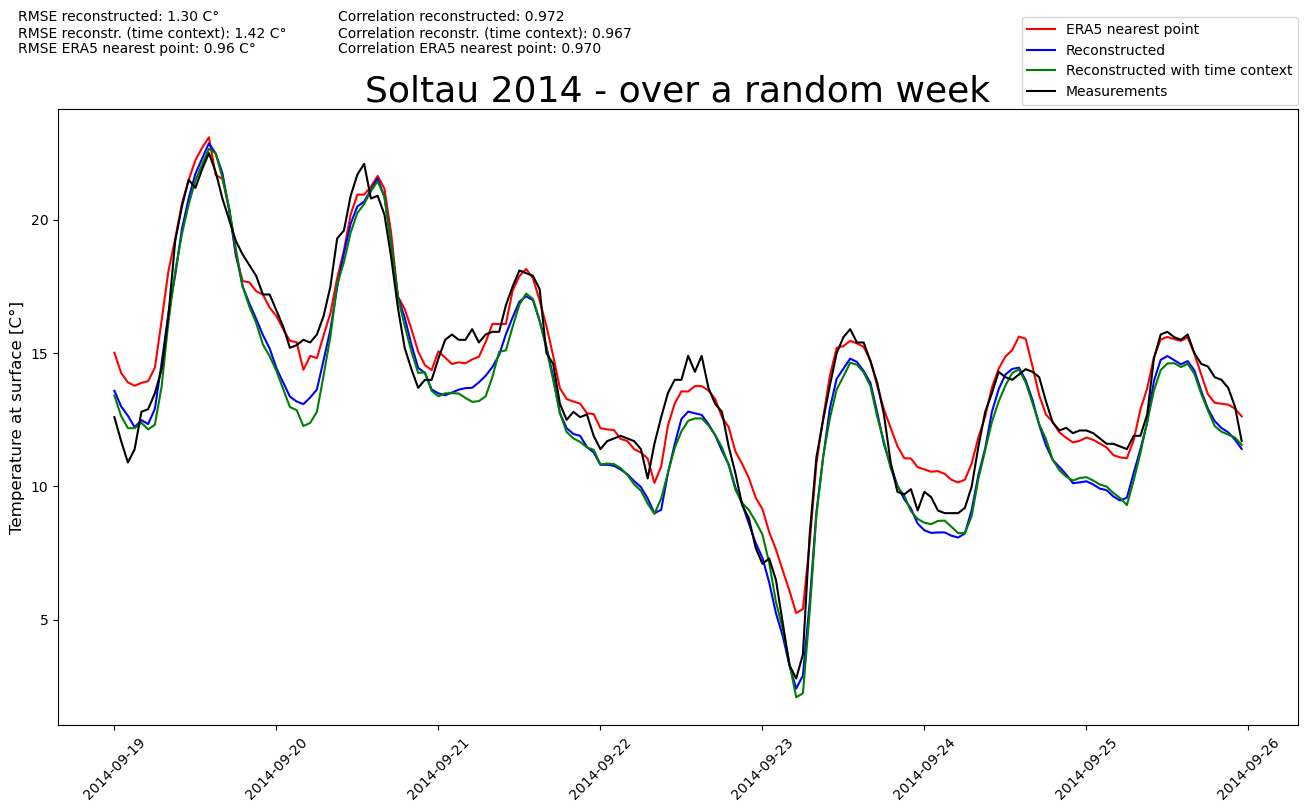

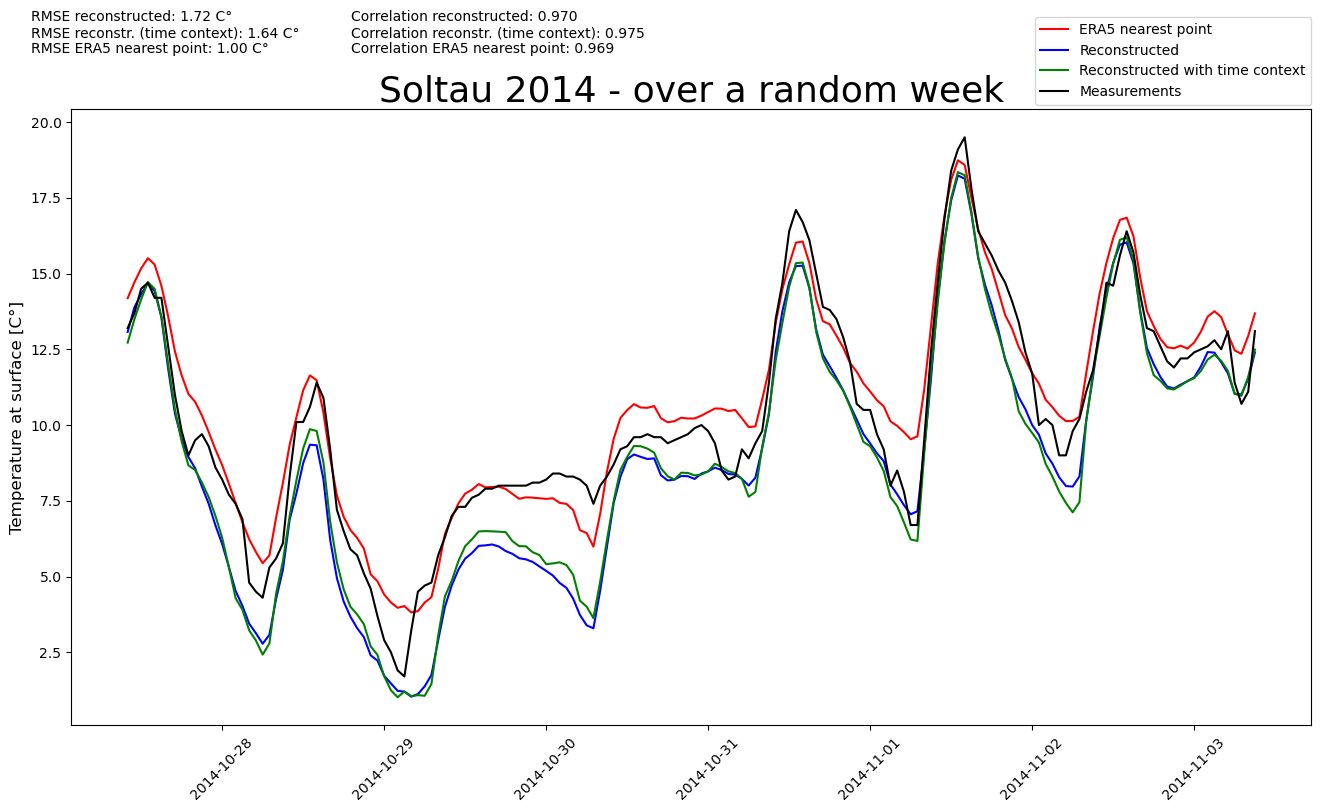

In [126]:
n = 168
if n == 168:
    title = f"{'Denver' if station_name == 'Marshall' else station_name} {test_year} - over a random week"
else:
    title = f"{'Denver' if station_name == 'Marshall' else station_name} {test_year} - {n} random consecutive hourly steps"
plot_n_steps_of_df(hourly_df, as_delta=False, n=n, title=title)
plot_n_steps_of_df(hourly_df, as_delta=False, n=n, title=title)
plot_n_steps_of_df(hourly_df, as_delta=False, n=n, title=title)

## Resample Data from hourly to daily or monthly




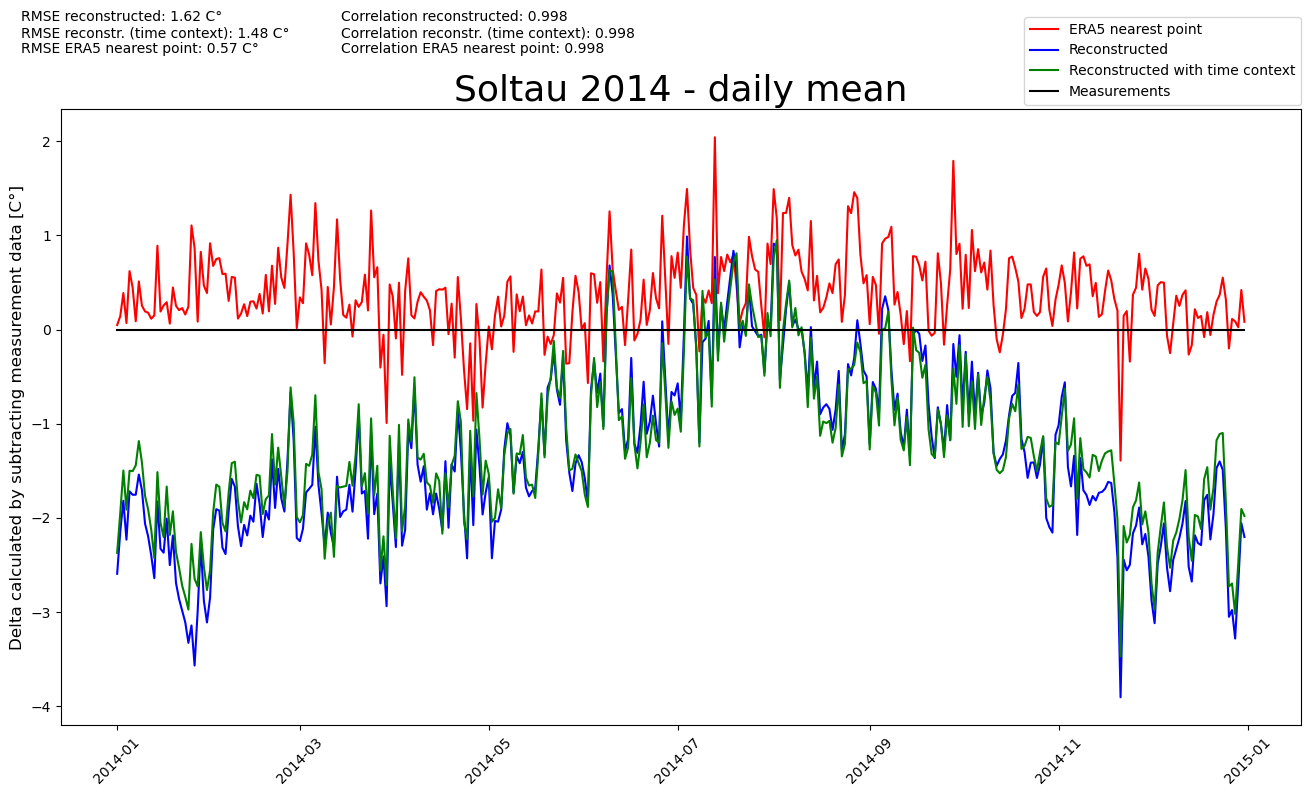

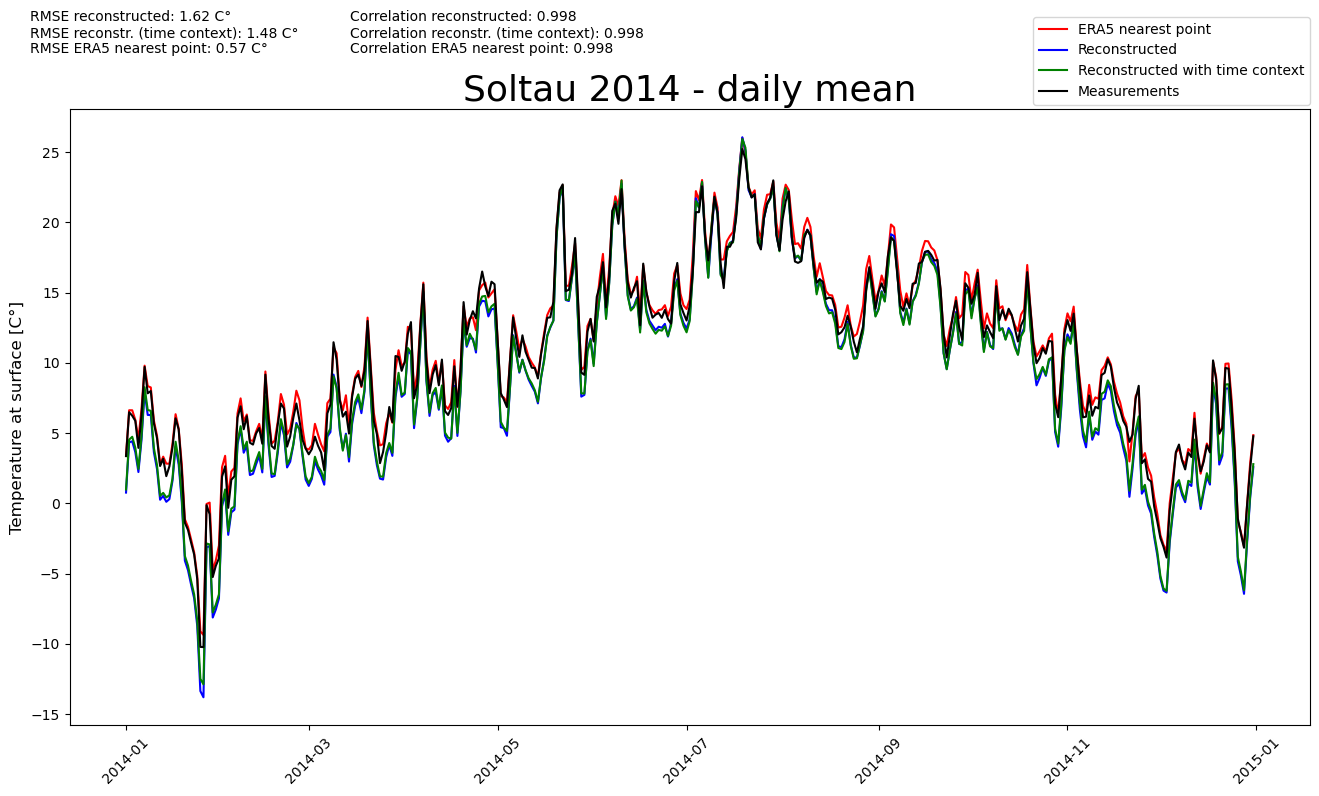

In [127]:
# resample to daily mean
daily_df = hourly_df.resample("D").mean()
# drop nans
daily_df = daily_df.dropna()
title = f"{'Denver' if station_name == 'Marshall' else station_name} {test_year} - daily mean"
plot_n_steps_of_df(daily_df, as_delta=True, title=title)
plot_n_steps_of_df(daily_df, as_delta=False, title=title)

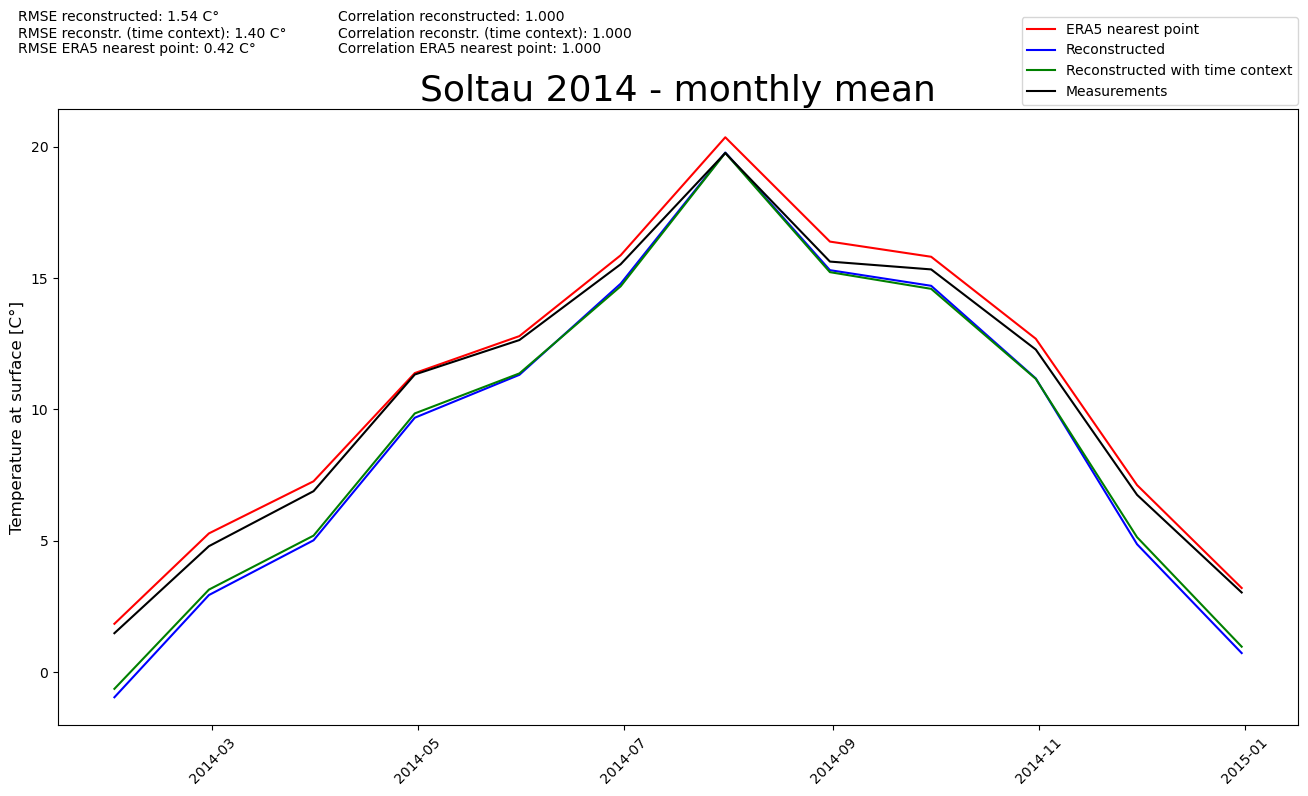

In [128]:
# resample rows to monthly mean
df = hourly_df.resample("M").mean()
title = f"{'Denver' if station_name == 'Marshall' else station_name} {test_year} - monthly mean"
plot_n_steps_of_df(df, as_delta = False, title=title)

# Average Course of the day

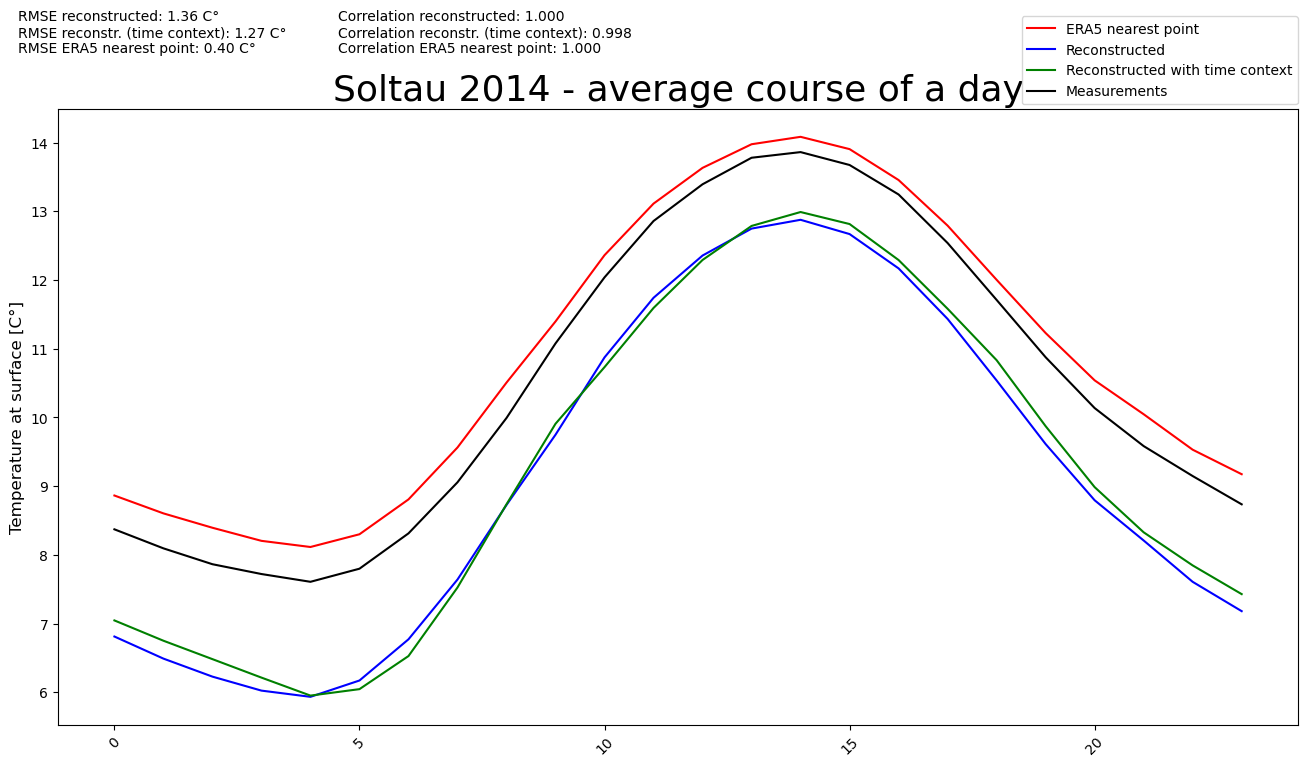

In [129]:
# calculate the mean of each 24 hours over the whole year

day_course_df = hourly_df.groupby(hourly_df.index.hour).mean()
title = f"{'Denver' if station_name == 'Marshall' else station_name} {test_year} - average course of a day"
plot_n_steps_of_df(day_course_df, as_delta = False, title=title)

# Average Course of the month

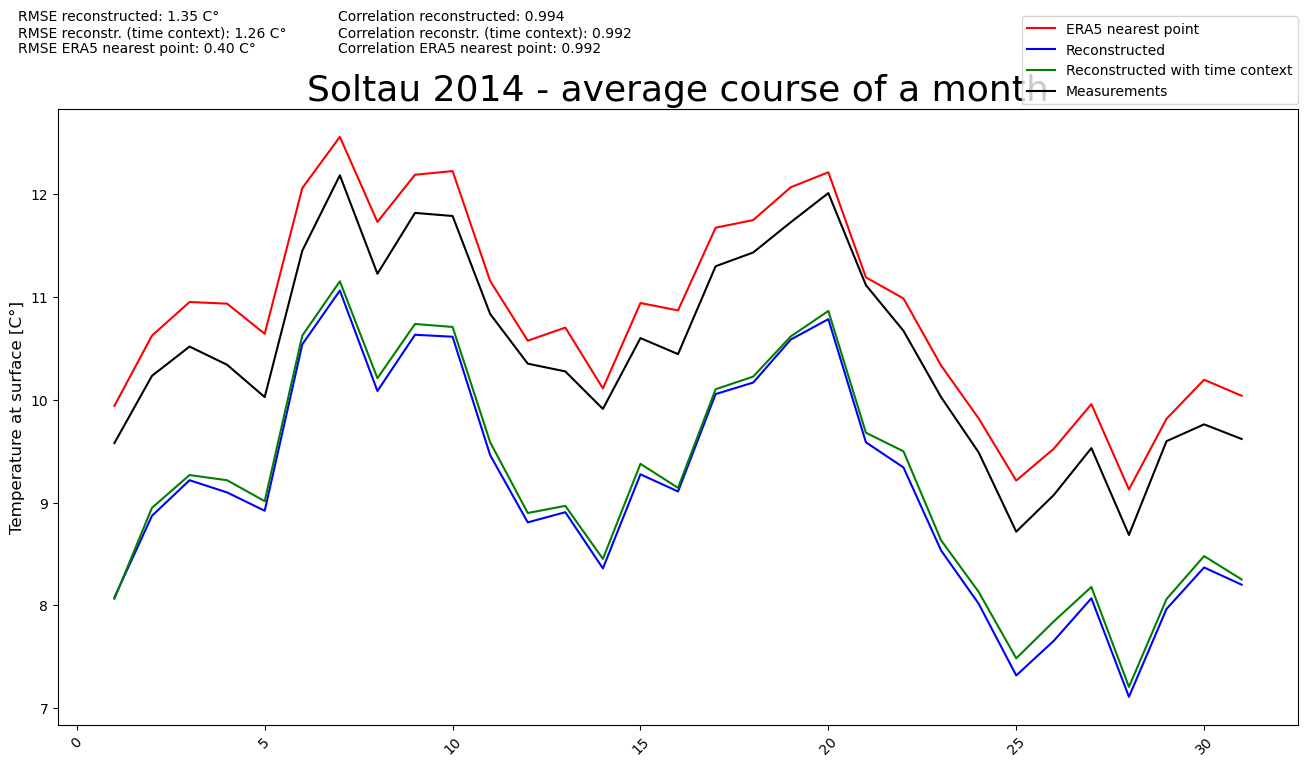

In [130]:
# calculate the mean of each day of a month over the whole year

month_course_df = hourly_df.groupby(hourly_df.index.day).mean()
title = f"{'Denver' if station_name == 'Marshall' else station_name} {test_year} - average course of a month"
plot_n_steps_of_df(month_course_df, as_delta = False, title=title)